# Lecture Week 7

This Jupyter Notebook has some code for the implementation of shingling, minhashing and locality sensitive hashing.

In [1]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [2]:
from nltk.corpus import gutenberg
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

The previous code lists all the documents of the Gutenberg corpus. You can see that it is a very small collection but it will suffice for this demonstration. The following code shows how you can read the text of one document.

In [3]:
emma = gutenberg.raw('austen-emma.txt')
emma[:200]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; an'

## Shingling

The following code can be used to find the set of k-shingles for a document.

In [4]:
def k_shingles(text, k):
    return set(nltk.ngrams(text, k))

In [5]:
k_shingles(emma, 3)

{('-', 'd', 'a'),
 ('l', 'a', '!'),
 ("'", ' ', 'h'),
 ('w', ' ', 'm'),
 ('u', 'x', 'u'),
 ('r', 'y', "'"),
 ('"', 'I', 'm'),
 (' ', 's', 'p'),
 ('w', '\n', 'v'),
 ('d', 'u', 'l'),
 ('-', '\n', 'W'),
 ('w', '\n', 'M'),
 ('h', ' ', 'n'),
 (' ', 'c', 'l'),
 ('-', 'f', 'e'),
 ('r', 'd', '?'),
 ('t', 'y', '!'),
 ('r', 'p', ','),
 ('-', 'p', 'o'),
 ('e', 'r', "'"),
 ('d', 'm', 'a'),
 ('\n', '`', 'I'),
 ('W', 'e', 'y'),
 ('u', 'p', 'o'),
 ('y', ' ', 'b'),
 ('p', 'o', 't'),
 ('l', 'u', 'm'),
 ('p', 'r', 'e'),
 ('M', 'A', 'D'),
 ('r', ' ', 'H'),
 ('t', 'h', "'"),
 ('_', 'b', 'l'),
 ('t', 'e', 'a'),
 (' ', '"', 'I'),
 ('M', 'a', 'd'),
 ('f', ',', '\n'),
 ('\n', 'e', 's'),
 ('k', ' ', 'm'),
 ('\n', '"', '-'),
 ('a', 'd', 'd'),
 ('e', 'd', ':'),
 ('p', 'u', 'b'),
 ('r', 'p', 'r'),
 ('l', 'e', 't'),
 ('u', 'c', 'y'),
 (')', '\n', 't'),
 ('n', '\n', 'f'),
 ('"', 'o', 'f'),
 ('`', 'g', 'i'),
 ('l', 'a', 'z'),
 ('s', ',', ' '),
 (' ', 'B', 'o'),
 ('o', 'u', 'r'),
 ('a', 'l', 'm'),
 ('u', ' ', 'a'),
 

The following code can be used to compute the jaccard similarity between two arbitrary sets.

In [6]:
def jaccard(set1, set2):
    return len(set1 & set2)/(len(set1 | set2))

And this code shows how to compute the jaccard similarity between the sets of 3-shingles for two documents in the Gutenberg corpus.

In [7]:
k3_shingles_emma = k_shingles(emma, 3)
persuasion = gutenberg.raw('austen-persuasion.txt')
k3_shingles_persuasion = k_shingles(persuasion, 3)
jaccard(k3_shingles_emma, k3_shingles_persuasion)

0.6289907557419232

The following code uses [Python's hash() function](https://docs.python.org/3/faq/design.html#how-are-dictionaries-implemented) to define our hash function that maps a shingle to a number within a specific range of values.

In [8]:
def my_hash(item, target_range):
    return hash(item) % target_range

This code illustrates how to use `my_hash`.

In [9]:
my_hash(('a','b','c'), 2**32)

596416136

*By using Python's `hash()` function we can hash many Python structures, not only k-shingles. However, Python's `hash()` function is implementation-dependent and might produce different output in different versions of Python. It might be even different on different runs of the Python shell. So this approach is not recommended for saving the signature matrix. But it will do for this demonstration.*

The code below uses the hash function to build the k_shingle of a document. It takes as a parameter the text, the value of k, the hash function, and the range of the hash function.

In [10]:
def k_hash_shingle(text, k, hash_function, target_range):
    return set(hash_function(item, target_range) 
               for item in nltk.ngrams(text, k))

In [11]:
k3_hash_shingle_emma = k_hash_shingle(emma, 3, my_hash, 2**32)
k3_hash_shingle_persuasion = k_hash_shingle(persuasion, 3, my_hash, 2**32)
jaccard(k3_hash_shingle_emma, k3_hash_shingle_persuasion)

0.6289907557419232

## Minhashing

The following code implements a different hash function for each value of `hash_index`.

In [12]:
def permute_hash(item, hash_index, target_range):
    return (hash(item) * (hash_index+1) + 1) % target_range

For example, here are the hash values of two strings for 10 different values of hash_index.

In [13]:
for i in range(10):
    print(permute_hash('a', i, 2**32), permute_hash('b', i, 2**32))

653407478 2977399125
1306814955 1659830953
1960222432 342262781
2613629909 3319661905
3267037386 2002093733
3920444863 684525561
278885044 3661924685
932292521 2344356513
1585699998 1026788341
2239107475 4004187465


The code below builds the signature matrix of the minhash of a list of k-shingles, where we can customize the permute hash functionm, the number of rows in the final signature matrix, and the target range of the permute hash function.

In [14]:
import numpy as np
def minhash(kshingles,
            permute_hash_function, signature_rows,
            target_range,
            verbose=False):
    sig = np.ones((signature_rows, len(kshingles))) * np.inf
    for r in range(target_range):
        #if r % 1000000 == 0:
        #    print("%d/%d" % (r, target_range))
        for c, ks in enumerate(kshingles):
            if r not in ks:
                continue
            for i in range(signature_rows):
                sig[i, c] = min(sig[i,c], 
                                permute_hash_function(r, i, target_range))
        if verbose:
            print("After scanning row %i" % r)
            print("Signature matrix:")
            print(sig)
    return sig

Below we can see some code that builds the signature matrix that we have covered in the lectures.

In [15]:
def simple_permute_hash(x, index, target_range):
    if index == 0:
        return (x + 1) % target_range
    else:
        return (3*x + 1) % target_range

In [16]:
kshingles = [{0, 3}, {2}, {1, 3, 4}, {0, 2, 3}]
minhash(kshingles, simple_permute_hash, 2, 5, verbose=True)

After scanning row 0
Signature matrix:
[[  1.  inf  inf   1.]
 [  1.  inf  inf   1.]]
After scanning row 1
Signature matrix:
[[  1.  inf   2.   1.]
 [  1.  inf   4.   1.]]
After scanning row 2
Signature matrix:
[[ 1.  3.  2.  1.]
 [ 1.  2.  4.  1.]]
After scanning row 3
Signature matrix:
[[ 1.  3.  2.  1.]
 [ 0.  2.  0.  0.]]
After scanning row 4
Signature matrix:
[[ 1.  3.  0.  1.]
 [ 0.  2.  0.  0.]]


array([[ 1.,  3.,  0.,  1.],
       [ 0.,  2.,  0.,  0.]])

## Plots of the S-Curve for Locality Sensitive Hashing

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
xrange = [x/100 for x in range(100)]

In [18]:
def yvalues(xrange, r, b):
    return [1-(1-s**r)**b for s in xrange]

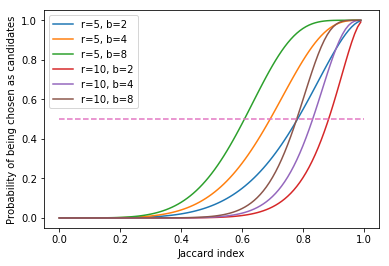

In [19]:
plt.plot(xrange, yvalues(xrange, 5, 2), label="r=%i, b=%i" % (5, 2))
plt.plot(xrange, yvalues(xrange, 5, 4), label="r=%i, b=%i" % (5, 4))
plt.plot(xrange, yvalues(xrange, 5, 8), label="r=%i, b=%i" % (5, 8))
plt.plot(xrange, yvalues(xrange, 10, 2), label="r=%i, b=%i" % (10, 2))
plt.plot(xrange, yvalues(xrange, 10, 4), label="r=%i, b=%i" % (10, 4))
plt.plot(xrange, yvalues(xrange, 10, 8), label="r=%i, b=%i" % (10, 8))
plt.plot([0,1], [0.5, 0.5], '--')
plt.xlabel("Jaccard index")
plt.ylabel("Probability of being chosen as candidates")
plt.legend()